In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
def preprocess_data(file_path):
    # Load the csv
    df = pd.read_csv(file_path)
    
    # Retain the desired columns
    desired_columns = [f"CH_{i}" for i in range(121, 2331)] + ['Mineral Phase']
    df = df[desired_columns]
    
    # Aggregate every 8 columns
    aggregated_data = []
    for i in range(121, 2324, 8):  # 2324 is 2330 - 8 + 1
        col_names = [f"CH_{j}" for j in range(i, i+8)]
        df[f"Agg_{i}_{i+7}"] = df[col_names].sum(axis=1)
        aggregated_data.append(f"Agg_{i}_{i+7}")
    
    # Keep only aggregated columns and 'Mineral Phase'
    df = df[aggregated_data + ['Mineral Phase']]
    
    return df

In [3]:
# Define the labels
labels = [
    "Fe-Oxide", "Background", "Ilmenite", "Epidote", "Amphibole", "AlFe-Silicate", "Fe-Silicate",
    "Titanite", "AlMn-Silicate", "Rutile", "Zircon", "Monazite", "Quartz", "Cassiterite",
    "AlK-Silicate", "Barite", "Al-Silicate", "Chromite", "Leucoxene", "Fe-Sulphide",
    "AlCa-Silicate", "Apatite", "Xenotime", "Carbonate"
]

In [4]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

all_dataframes = []

for label in labels:
    file_path = f"E:\\CP_processed_data\\{label}.csv"
    print(f"Loading and preprocessing the data for {label}...")
    df = preprocess_data(file_path)
    print(f"Loaded {len(df)} samples for {label}.")
    all_dataframes.append(df)

print("All data files loaded and preprocessed.")
print("Concatenating all preprocessed data...")

combined_df = pd.concat(all_dataframes, axis=0)
print(f"Combined dataset shape: {combined_df.shape}")

X = combined_df.drop(columns='Mineral Phase')
y = combined_df['Mineral Phase']

labels_to_upsample = ['Xenotime', 'Carbonate']
oversampler = SMOTE(sampling_strategy={label: 12500 for label in labels_to_upsample}, random_state=42)
undersampler = RandomUnderSampler(sampling_strategy={class_name: 12500 for class_name in y.unique()}, random_state=42)

pipeline = Pipeline([
    ('oversample', oversampler),
    ('undersample', undersampler)
])

print("Applying the resampling pipeline...")
X_resampled, y_resampled = pipeline.fit_resample(X, y)

resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
resampled_df['Mineral Phase'] = y_resampled

print(resampled_df.head())

Loading and preprocessing the data for Fe-Oxide...
Loaded 19800 samples for Fe-Oxide.
Loading and preprocessing the data for Background...
Loaded 19800 samples for Background.
Loading and preprocessing the data for Ilmenite...
Loaded 19800 samples for Ilmenite.
Loading and preprocessing the data for Epidote...
Loaded 24721 samples for Epidote.
Loading and preprocessing the data for Amphibole...
Loaded 25101 samples for Amphibole.
Loading and preprocessing the data for AlFe-Silicate...
Loaded 27169 samples for AlFe-Silicate.
Loading and preprocessing the data for Fe-Silicate...
Loaded 27800 samples for Fe-Silicate.
Loading and preprocessing the data for Titanite...
Loaded 27800 samples for Titanite.
Loading and preprocessing the data for AlMn-Silicate...
Loaded 27800 samples for AlMn-Silicate.
Loading and preprocessing the data for Rutile...
Loaded 27800 samples for Rutile.
Loading and preprocessing the data for Zircon...
Loaded 27800 samples for Zircon.
Loading and preprocessing the da

C:\Users\61596\AppData\Local\Temp\ipykernel_25636\2186499594.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  resampled_df['Mineral Phase'] = y_resampled


In [10]:
def plot_mineral_phase(df):    
    # Group by 'Mineral Phase' and calculate the mean for each channel
    grouped_df = df.groupby('Mineral Phase').mean()

    plt.figure(figsize=(15, 7))

    # Plotting each mineral phase
    for mineral in grouped_df.index:
        plt.plot(grouped_df.columns, grouped_df.loc[mineral], label=mineral)

    # Setting x-ticks
    num_columns = len(grouped_df.columns)
    ticks = list(range(0, num_columns, 30))
    labels = [grouped_df.columns[i] for i in ticks]

    plt.xticks(ticks, labels, rotation=45)

    plt.title('Average Channel Counts by Mineral Phase')
    plt.xlabel('Channels')
    plt.ylabel('Average Count')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.tight_layout()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

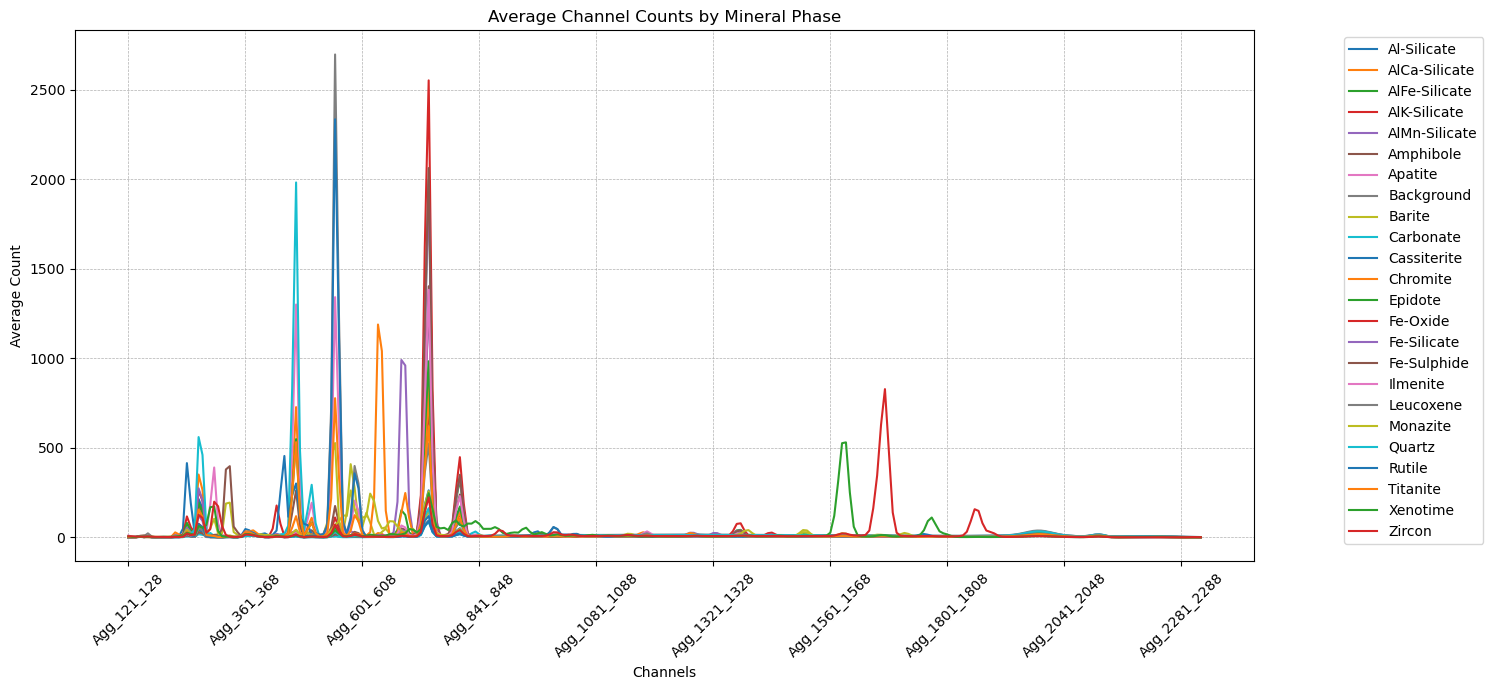

In [9]:
plot_mineral_phase(resampled_df)

## Preparation of Training&Testing for Model Building

In [4]:
#Load data for training
path = "E:\\CP_processed_data\\resampled_data.csv"

df = pd.read_csv(path)

print(f"Data loaded from {path}. Shape: {df.shape}")

Data loaded from E:\CP_processed_data\resampled_data.csv. Shape: (300000, 277)


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

def standardize_training_set(df, target_column):
    global scaler
    
    # Separate features and target
    features = df.drop(columns=target_column)
    target = df[target_column]
    
    # Apply logarithmic transformation. Add a small constant to avoid log(0)
    log_transformed_features = np.log(features + 1)

    # Fit and transform the features
    standardized_features = scaler.fit_transform(log_transformed_features)

    # Convert back to DataFrame and add the target column back
    standardized_df = pd.DataFrame(standardized_features, columns=features.columns)
    standardized_df[target_column] = target.values
    
    return standardized_df

def transform_dataset(df, target_column):
    global scaler

    # Separate features and target
    features = df.drop(columns=target_column)
    target = df[target_column]
    
    # Apply logarithmic transformation. Add a small constant to avoid log(0)
    log_transformed_features = np.log(features + 1)

    # Transform the features
    standardized_features = scaler.transform(log_transformed_features)

    # Convert back to DataFrame and add the target column back
    standardized_df = pd.DataFrame(standardized_features, columns=features.columns)
    standardized_df[target_column] = target.values

    return standardized_df

In [7]:
from sklearn.model_selection import train_test_split

# Shuffle the dataframe
shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the dataframe
X = shuffled_df.drop(columns='Mineral Phase')
y = shuffled_df['Mineral Phase']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")

Training data shape: (240000, 276), Testing data shape: (60000, 276)


In [8]:
# Standardizing the datasets
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

standardized_train_df = standardize_training_set(train_df,'Mineral Phase')
standardized_test_df = transform_dataset(test_df,'Mineral Phase')

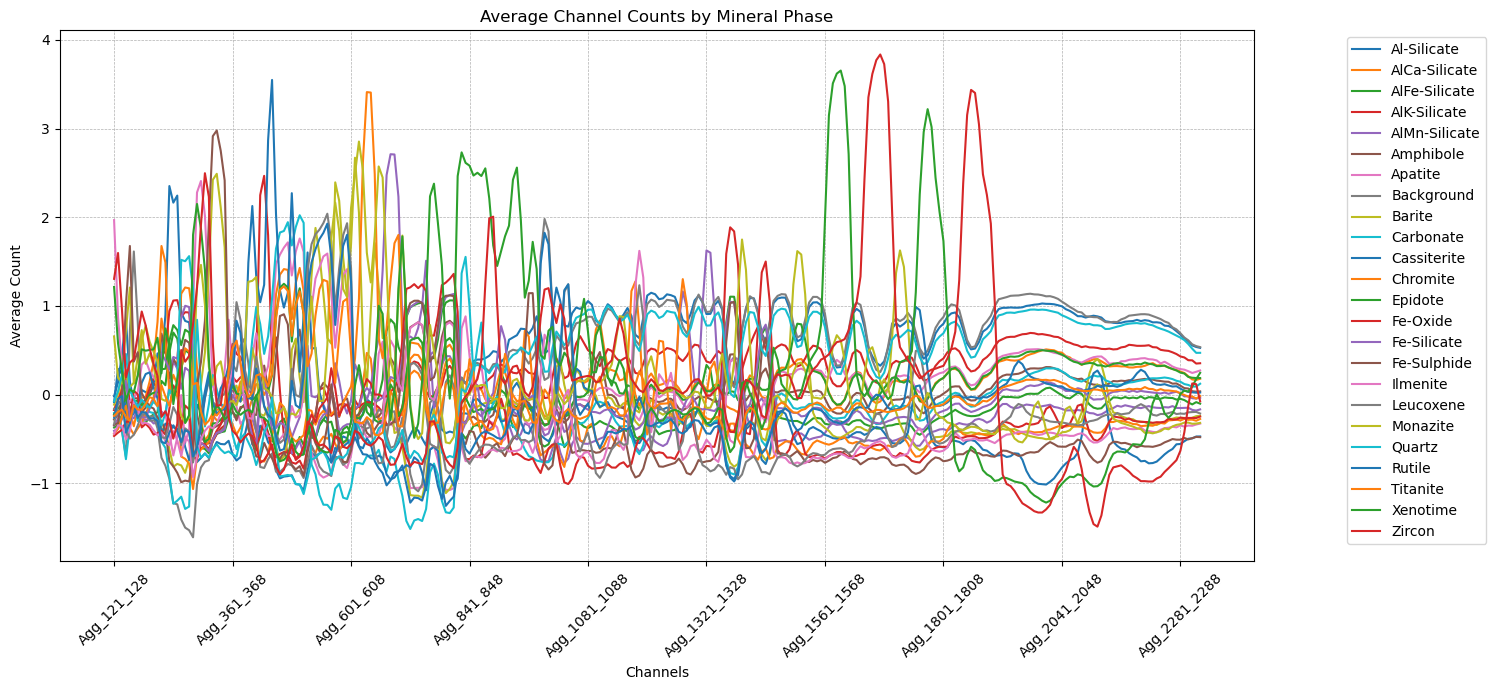

In [11]:
plot_mineral_phase(standardized_train_df)

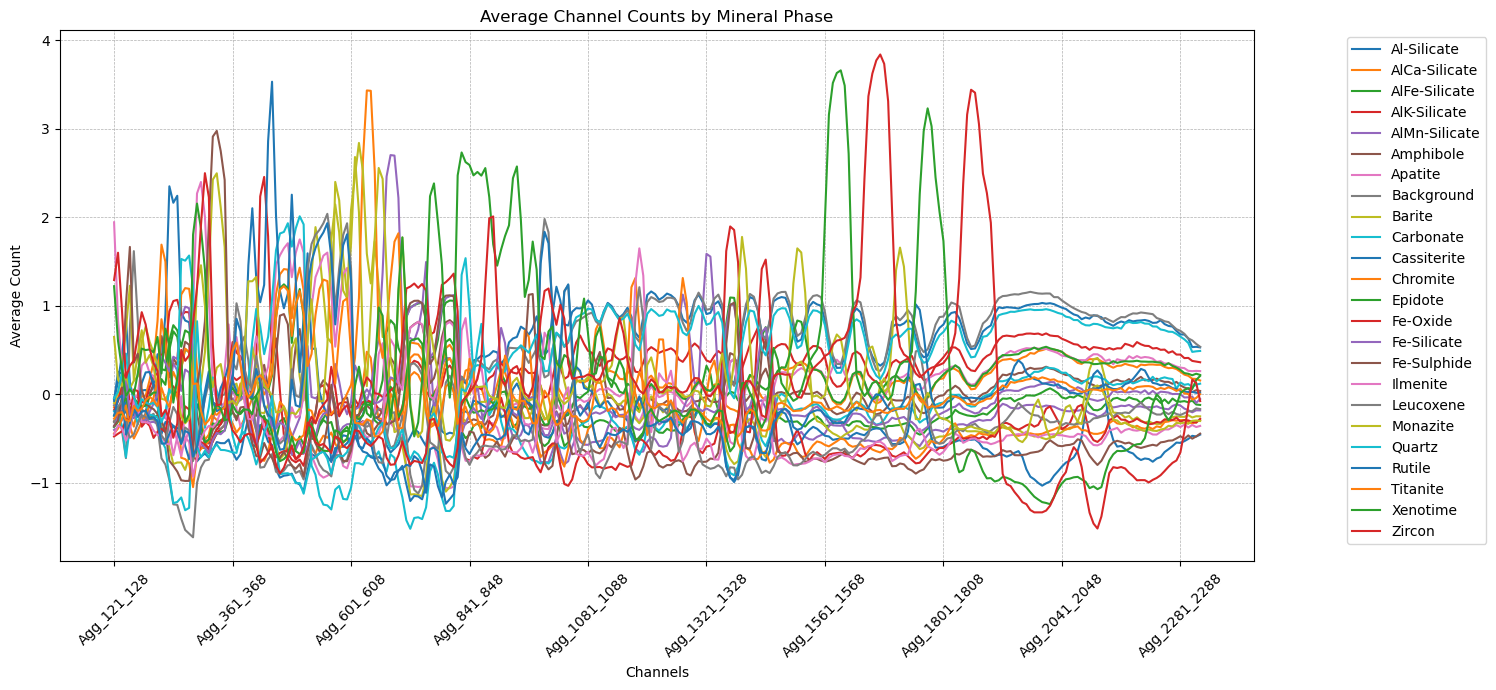

In [12]:
plot_mineral_phase(standardized_test_df)

In [15]:
standardized_train_df.to_csv('training.csv', index = False)
standardized_test_df.to_csv('testing.csv', index = False)

## Testing Data(Unseen) Processing

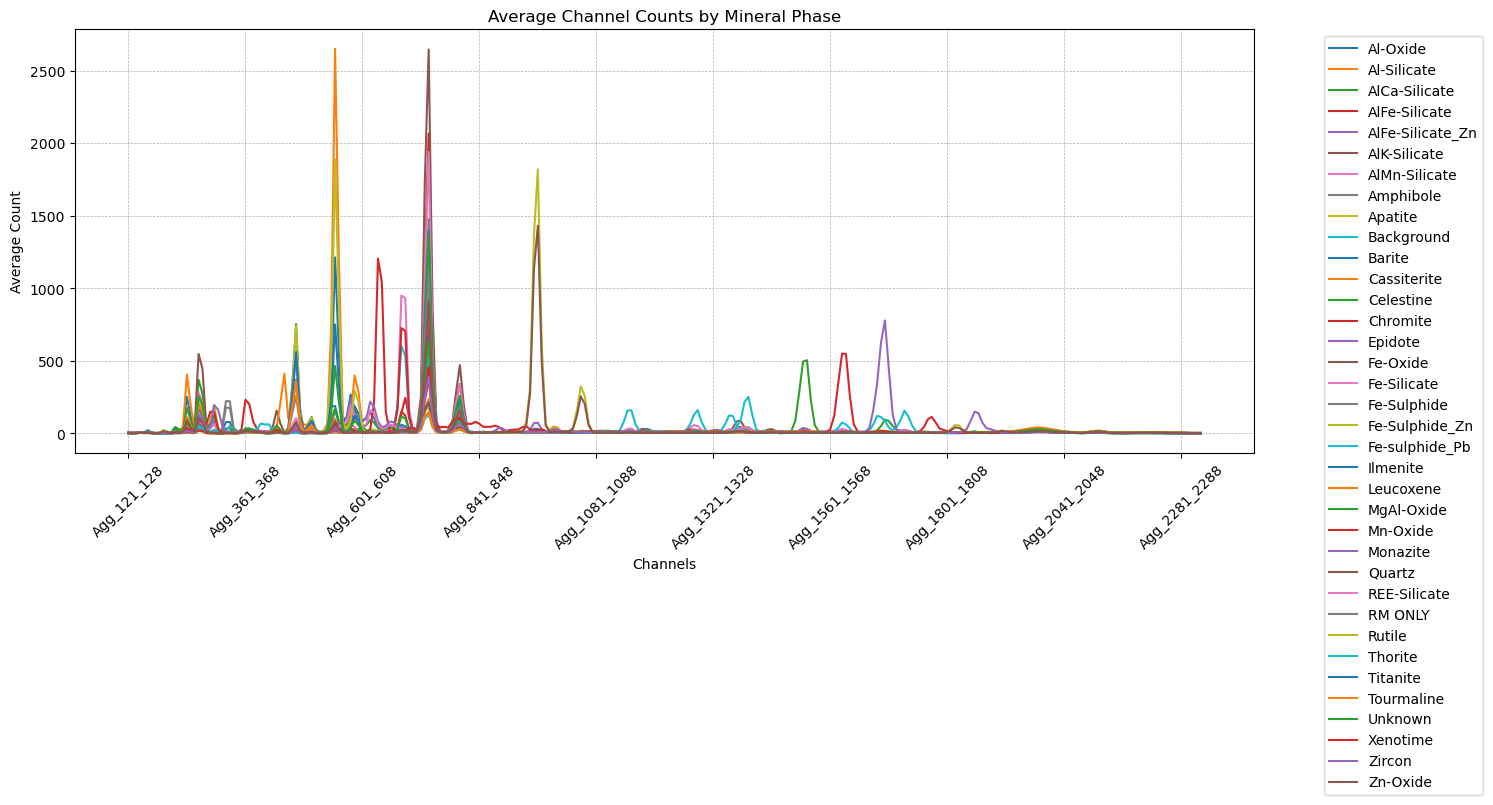

In [16]:
path = r"C:\Users\61596\10_combined_shuffled.csv"
df_v = preprocess_data(path)
plot_mineral_phase(df_v)

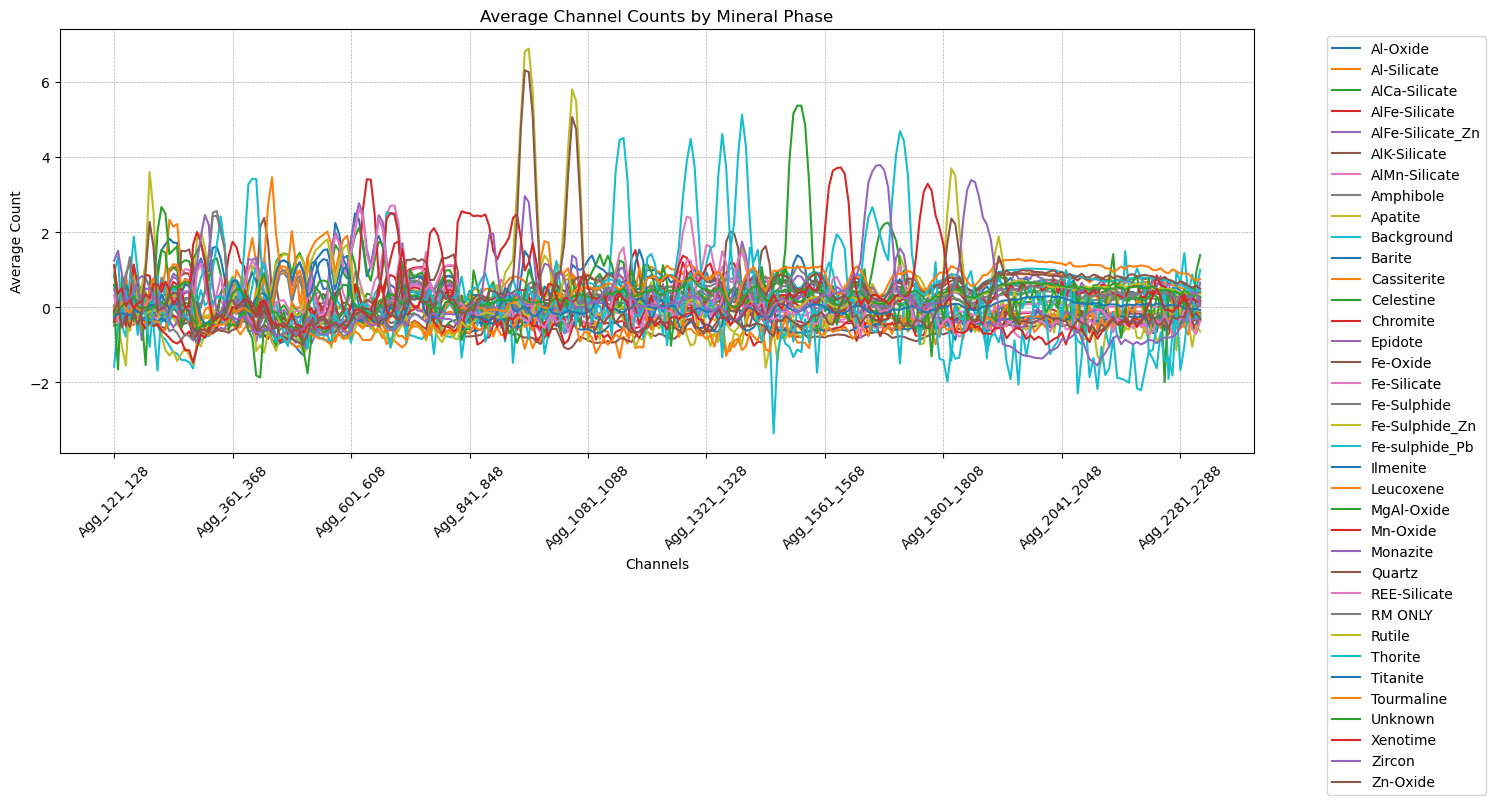

In [17]:
df_v = transform_dataset(df_v, 'Mineral Phase')
plot_mineral_phase(df_v)

In [18]:
df_v.to_csv("10_transformed.csv", index=False)

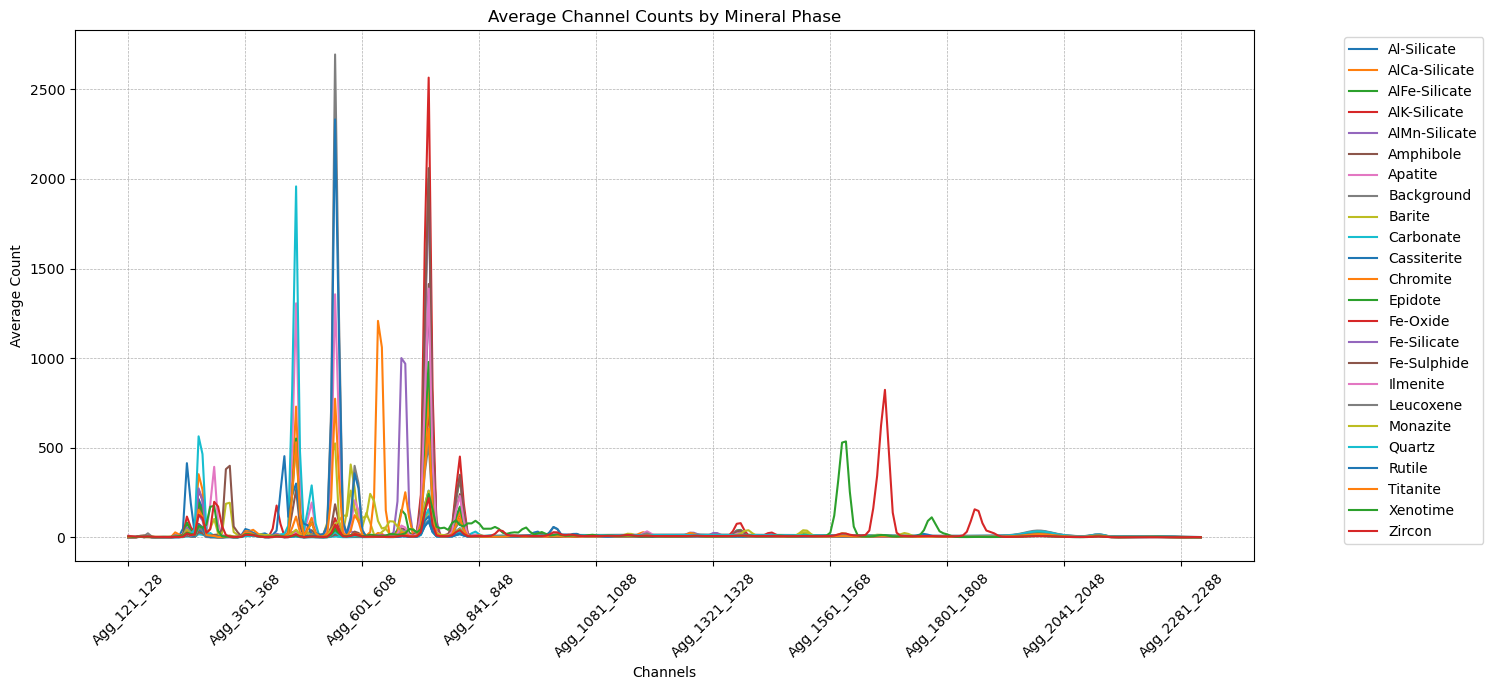

In [24]:
path = r"C:\Users\61596\balanced_testing_set.csv"
df_b = pd.read_csv(path)
plot_mineral_phase(df_b)

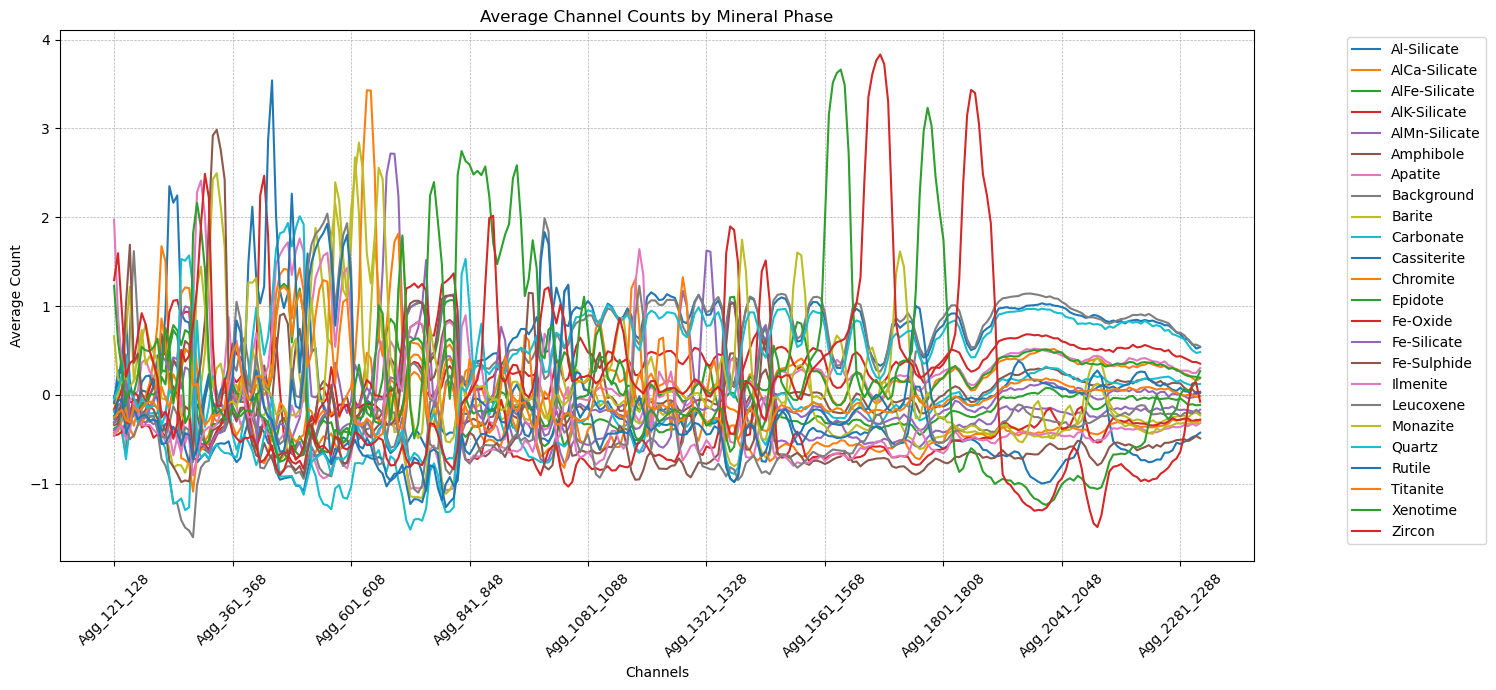

In [25]:
df_b = transform_dataset(df_b, 'Mineral Phase')
plot_mineral_phase(df_b)

In [26]:
df_b.to_csv("balanced_transformed.csv", index=False)